In [5]:
# Import external modules
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Import internal modules
from project.data.clean_data import df
from utils.helpers import timeseries_to_array

In [8]:
df.head()

,datetime,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close
96,2020-01-02 00:00:00,1.12184,1.12186,1.12156,1.12157,1.12198,1.12199,1.12167,1.12168
97,2020-01-02 00:15:00,1.12154,1.12164,1.12151,1.12155,1.12168,1.12177,1.12165,1.12169
98,2020-01-02 00:30:00,1.12157,1.12169,1.12152,1.12167,1.12169,1.12182,1.12164,1.12181
99,2020-01-02 00:45:00,1.12169,1.12183,1.12169,1.12178,1.12181,1.12197,1.12181,1.12191
100,2020-01-02 01:00:00,1.12177,1.12225,1.12176,1.12221,1.12190,1.12238,1.12188,1.12234


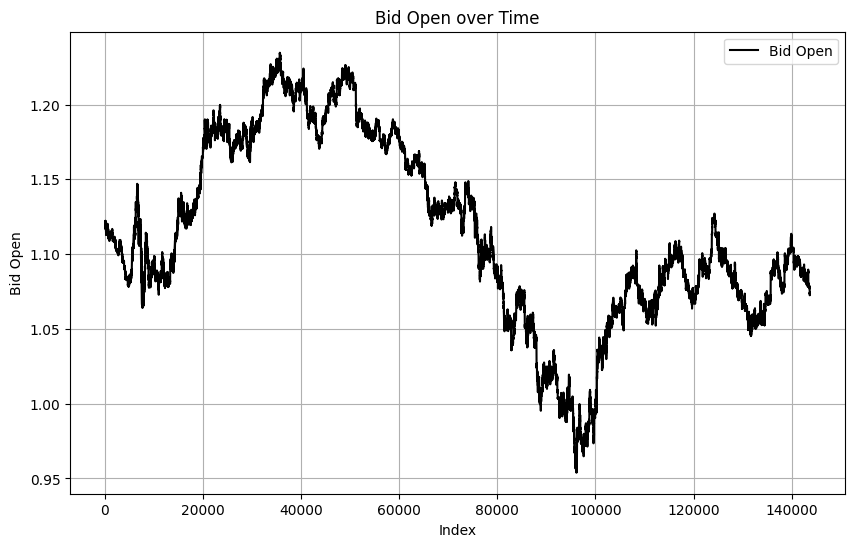

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot 'bid_open' as a line plot
plt.figure(figsize=(10, 6))
# Plotting index instead of datetime, since Nan removal leads to inconsistent spacing
plt.plot(df.index, df['bid_open'], label='Bid Open', color='black')
plt.title('Bid Open over Time')
plt.xlabel('Index')
plt.ylabel('Bid Open')
plt.legend()
plt.grid(True)
plt.show()